In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plots # Custom functions for plotting

# Tricking your cerebellum
## Task 3: Feedback

By: Ieva Kerseviciute* and Robin Uhrich*

*equal contribution

## Task 1: Implementation of feedback_types

The experimental flow is as follows:

1. Normal feedback type with gradual perturbation
2. Trajectory feedback type with gradual perturbation
3. End position feedback type with gradual perturbation
4. RL feedback type with gradual perturbation
5. Normal feedback type with sudden perturbation (novel implementation for **task 4**)

Each block has three parts:

1. 10 blocks without perturbation
2. 30 blocks with perturbation, either increasing in 0.2 degrees every 3 attempts in case of gradual perturbation, or a sudden increase of 2 degrees in case of sudden perturbation
3. 10 blocks without perturbation

Implementation for different feedback types:

```{python}
def draw_feedback():
    """Display feedback based on the feedback type."""

    global feedback_type

    # Reset
    pygame.draw.circle(screen, BLACK, START_POS, FREE_ZONE_RADIUS, 3)

    if feedback_type is None:
        return

    if feedback_type == "trajectory":
        # Draw the trajectory of the previous throw
        for point in previous_trajectory:
            pygame.draw.circle(screen, WHITE, (int(point[0]), int(point[1])), 2, 2)

    if feedback_type == "rl":
        # Draw a circle around the throw point
        color = GREEN_LAMP if previous_win else RED_LAMP
        pygame.draw.circle(screen, color, START_POS, FREE_ZONE_RADIUS, 10)

    if feedback_type == "endpos":
        # Show the final position of the pint
        if previous_pos is not None:
            pygame.draw.circle(screen, WHITE, (int(previous_pos[0]), int(previous_pos[1])), pint_radius + 2, 2)
```

Experimental design:

```{python}
# 10 trials without perturbation
# 30 trials with gradual perturbation
# 10 trials without perturbation

block_structure = [
    # Normal visual feedback
    {"feedback": None, "perturbation": False, "gradual": False, "num_trials": 10},
    {"feedback": None, "perturbation": True, "gradual": True, "num_trials": 30, "initial_force": 0.2, "sudden_force": 2.0},
    {"feedback": None, "perturbation": False, "gradual": False, "num_trials": 10},

    # Trajectory feedback
    {"feedback": "trajectory", "perturbation": False, "gradual": False, "num_trials": 10},
    {"feedback": "trajectory", "perturbation": True, "gradual": True, "num_trials": 30, "initial_force": 0.2, "sudden_force": 2.0},
    {"feedback": "trajectory", "perturbation": False, "gradual": False, "num_trials": 10},

    # End position feedback
    {"feedback": "endpos", "perturbation": False, "gradual": False, "num_trials": 10},
    {"feedback": "endpos", "perturbation": True, "gradual": True, "num_trials": 30, "initial_force": 0.2, "sudden_force": 2.0},
    {"feedback": "endpos", "perturbation": False, "gradual": False, "num_trials": 10},

    # RL feedback
    {"feedback": "rl", "perturbation": False, "gradual": False, "num_trials": 10},
    {"feedback": "rl", "perturbation": True, "gradual": True, "num_trials": 30, "initial_force": 0.2, "sudden_force": 2.0},
    {"feedback": "rl", "perturbation": False, "gradual": False, "num_trials": 10},

    # Normal visual feedback and sudden perturbation
    {"feedback": None, "perturbation": False, "gradual": False, "num_trials": 10},
    {"feedback": None, "perturbation": True, "gradual": False, "num_trials": 30, "sudden_force": 2.0},
    {"feedback": None, "perturbation": False, "gradual": False, "num_trials": 10}
]
```

## Task 2: Analysis of feedback on unbiased subjects

For this task, we recorded data from two unbiased subjects. We are including some of their comments while performing the task:

- Subject 1:
    - The line between failure and perfection in this game is very thin 
    - In life, sometimes it's better not to know (during the blocks with masked trajectory)

- Subject 2:
    - If the eye cannot see, the heart cannot hurt (during the blocks with masked trajectory)
    - This is making me anxious, I don't see it, and then it's like a surprise (during the blocks with masked trajectory)
    - I hate it, my brain says to my hand to go fast and my hand doesn't (noticing that they are constantly undershooting)

Both subjects did not notice the gradual perturbation during the first 4 experimental blocks. Both subjects blamed themselves for "performing a strange throw" when the sudden perturbation of the last block started.

In [2]:
# Read subject data
experiment, full_experiment = plots.define_experiment()

subject1 = pd.read_csv("Subject_1.csv")
subject1 = pd.merge(subject1, full_experiment, on = "Trial")

subject2 = pd.read_csv("Subject_2.csv")
subject2 = pd.merge(subject2, full_experiment, on = "Trial")

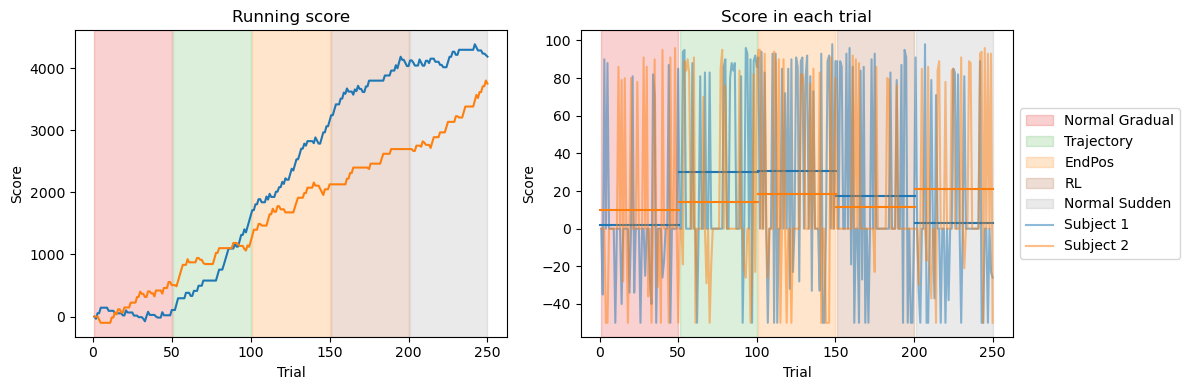

In [3]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
plots.plot_running_score(experiment, subjects = [subject1, subject2], ax = axs[0], show_legend = False)
plots.plot_trial_score(experiment, subjects = [subject1, subject2], ax = axs[1])
fig.tight_layout()

**Figure 1.** (Left) The running score across the experiment and (right) the score for each trial, with vertical lines representing the mean score for each block, for subjects 1 and 2. The different experimental blocks are visually highlighted. Subject 2 demonstrates a steady improvement in task performance throughout the experiment, while subject 1 shows a significant decline in performance during the final block, despite the movement of the pint being visible. Subject 1 reported that performing the task was easier when the movement of the pint was not revealed, as in the Trajectory, EndPos, and RL blocks. Conversely, subject 2 found the RL block to be the most challenging.

### Subject 1

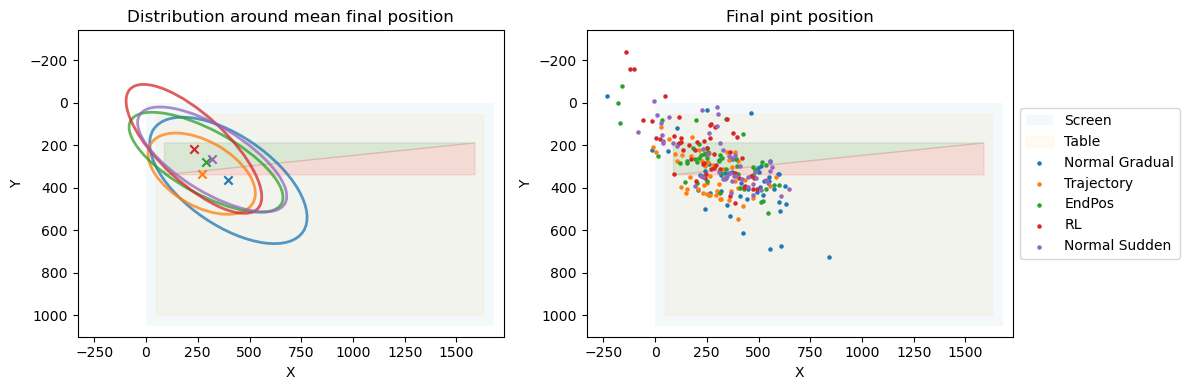

In [4]:
plots.plot_throw_positions(subject1)

**Figure 2.1.** Final pint positions for subject 1. (Right) The mean final position, marked by a cross, and its error, marked by the confidence ellipse. (Left) Final pint position for all trials. The experimental blocks are marked by different colors. The subject was undershooting during the first experimental block (Normal Gradual) as they were learning to perform the task. Of the remainder of experimental blocks, the final positions have the largest variance during the RL block, and the lowest variance during the Trajectory block.

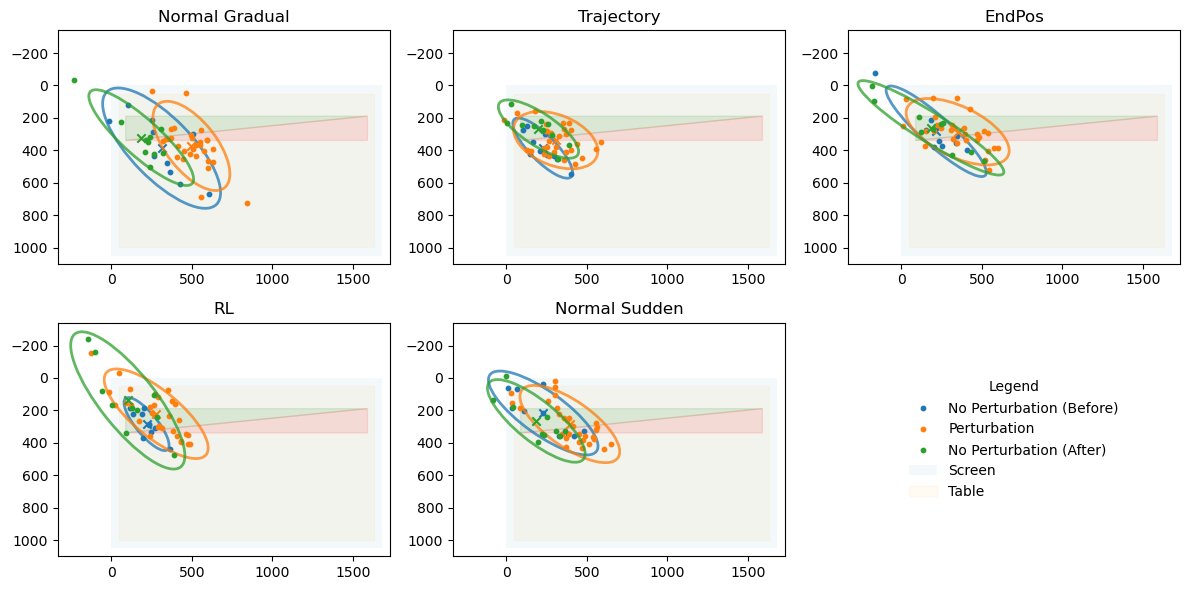

In [5]:
plots.plot_throw_perturbation(subject1)

**Figure 2.2.** Final pint positions, their mean and confidence ellipse during no perturbation and perturbation periods of each experimental block for subject 1. For all blocks, perturbed attempts are shifted in the direction of perturbation. In Normal Gradual, RL, and Normal Sudden blocks there is a visible after-effect, and the mean of the final position is shifted in the direction opposite to perturbation (in Trajectory and EndPos blocks it is not so enhanced).

### Subject 2

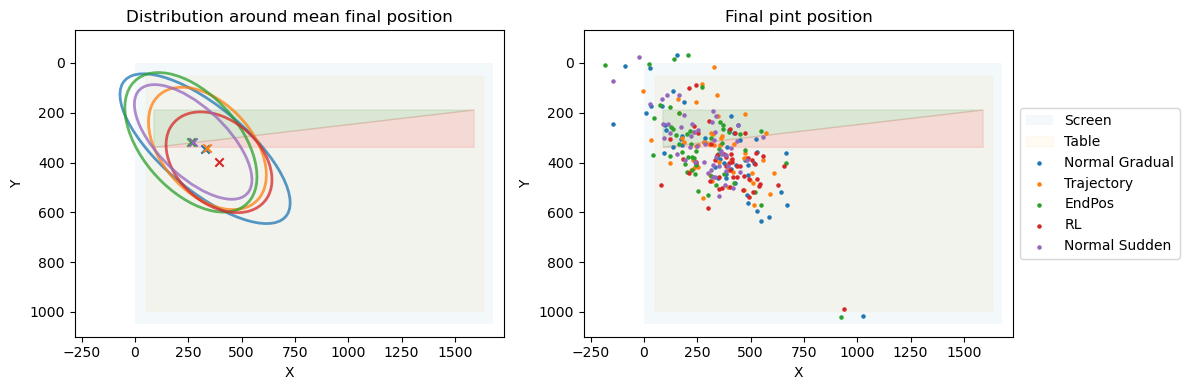

In [6]:
plots.plot_throw_positions(subject2)

**Figure 3.1.** Final pint positions for subject 2. (Right) The mean final position, marked by a cross, and its error, marked by the confidence ellipse. (Left) Final pint position for all trials. The experimental blocks are marked by different colors. The subject was constantly undershooting. Moreover, in three trials, they accidentally threw the pint in the opposite direction while aiming for the target (these trials were removed when computing the confidence ellipse and block means). In general, the variance of the final position is comparable between all experimental blocks, except for the clear undershooting in the RL block.

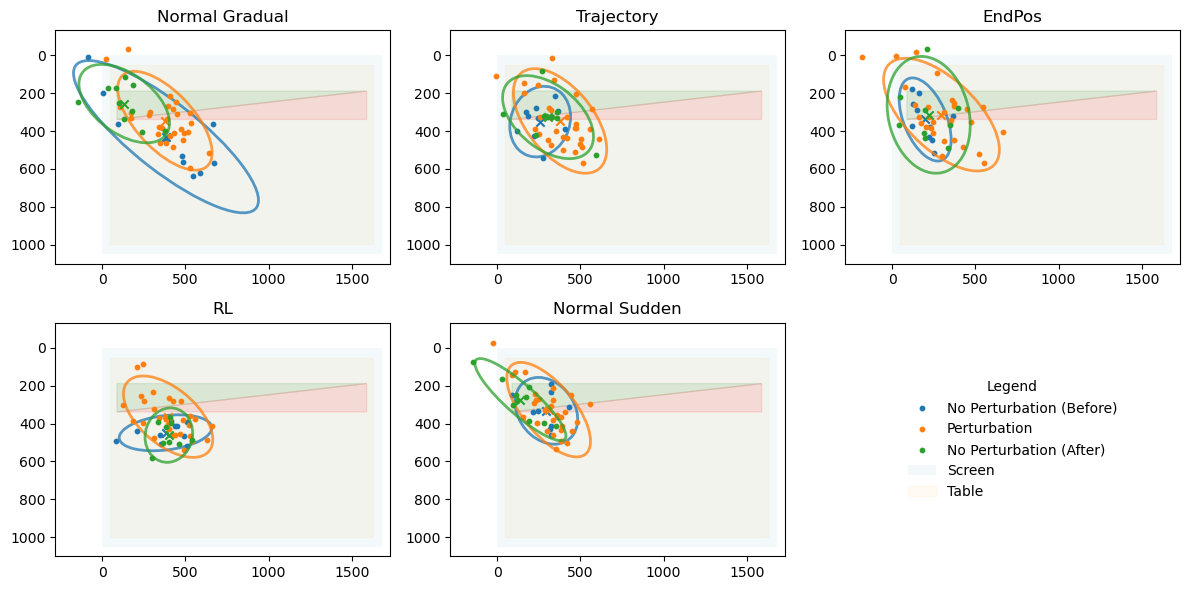

In [7]:
plots.plot_throw_perturbation(subject2)

**Figure 3.2.** Final pint positions, their mean and confidence ellipse during no perturbation and perturbation periods of each experimental block for subject 2. For this subject, the perturbation effect is not as clear as for the subject 1, as the perturbed attempts are overlapped with the non-perturbed ones. There is, however, a visible after-effect for the Normal Gradual and Normal Sudden blocks.

## Task 3: Discussion of your results

It is worth mentioning that it is difficult to assess the subjects' performance and interpret the results of the first experimental block (Normal Gradual). Based on the comments and reactions of the subjects, it was clear that they were adjusting to the task and the game system for the majority of the attempts of this block. We found it beneficial to include another Normal feedback type at the end of the experiment, even with the sudden perturbation mode, to better evaluate the effect of this type of feedback. Another interesting point to note is that each subject seemed to find different feedback types easier or more difficult to perform at.

**What is the effect on subject's performance of each feedback type?**

_Subject 1._ The subject mentioned that it was easier for them to aim when the movement of the pint was hidden, which is visible in the low average score during the Normal feedback trials (both Gradual and Sudden) (Figure 1 Right). The subject's attempts showed the least variability for the Trajectory feedback type (Figure 2.2 Trajectory). During the EndPos and RL blocks, the variability was the largest, with the largest number of attempts of overshooting (Figure 2.1, Figure 2.2 EndPos and RL).

_Subject 2._ The subject performed the best during the Normal Sudden block (Figure 1 Right, Figure 3.1). It can be argued that the high variability and low score in the Normal Gradual block was due to the learning curve for the task. During the Trajectory and EndPos blocks the final position variability was the largest (Figure 3.2 Trajectory and EndPos), during the RL block the number of collected points (and thus the accuracy) was the lowest (Figure 1 Right, Figure 3.2 RL).

Overall, the RL feedback type, and thus the reinforcement learning paradigm with only the reward / no reward signal, was the least effective for the task. With the other types of feedback, the subject could still update the internal model leading to the result, and the performance did not suffer strongly or even improved, even when the pint movement was hidden.

**Under which feedback type was your subject able to adapt the best?**

In the Normal Gradual block, both subjects initially perform somewhat randomly during the first 10 unperturbed attempts. Later, they learn the task, adjust to the perturbation, and exhibit an after-effect during the final 10 unperturbed attempts. The mean of the last unperturbed attempts is shifted in the opposite direction of the perturbation (Figures 2.2 and 3.2, Normal Gradual).

A similar pattern is observed in the Normal Sudden block, where subjects also adapt to the perturbation, as shown by their after-effects (Figures 2.2 and 3.2 Normal Sudden).

In contrast, for the Trajectory and EndPos blocks, the subjects seem to ignore the perturbation. The mean final positions for unperturbed attempts both before and after the perturbation are close to each other, with only a slight shift in the direction of the perturbation for the perturbed trials (Figures 2.2 and 3.2, Trajectory and EndPos).

The results for the RL block are less conclusive. Subject 1 appears to adapt to the perturbation, as indicated by the after-effect (Figure 2.2, RL). Subject 2, however, does not exhibit a noticeable shift in the direction of the perturbation (Figure 3.2, RL).

Overall, subjects adapt best to the perturbation with the Normal feedback type (both Gradual and Sudden).
